# Predict Yelp rating from review text

In [1]:
import pandas as pd
import numpy as np
import json
import sys

In [2]:
from src import *

business_df = pd.read_json('../database/yelp_academic_dataset_business.json', lines=True)
review_df = pd.read_json('../database/yelp_academic_dataset_review.json', lines=True)

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
main_color = ['#00754B', '#C8FCEA', '#6A9A8B']

In [4]:
# Filter out all businesses that belong to the "Restaurant" category
restaurants = business_df[business_df['categories'].str.contains(
    'Restaurant') == True]

# Filter out reviews whose business_id exists in the list of restaurant business IDs
restaurant_reviews = review_df[review_df.business_id.isin(
    restaurants['business_id']) == True]

print(f"Dimensions of restaurant_reviews dataframe: {restaurant_reviews.shape}")

Dimensions of restaurant_reviews dataframe: (4724684, 9)


## Part One: Use the Naive Bayes method for prediction

In [5]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [6]:
# Calculate the size of the training set as 70% of the entire dataset
train_size = int(len(restaurant_reviews) * 0.7)

train = restaurant_reviews[:train_size]
test = restaurant_reviews[train_size:]

print(f"Training dataset dimensions: {train.shape}")
print(f"Test dataset dimensions: {test.shape}")

Training dataset dimensions: (3307278, 9)
Test dataset dimensions: (1417406, 9)


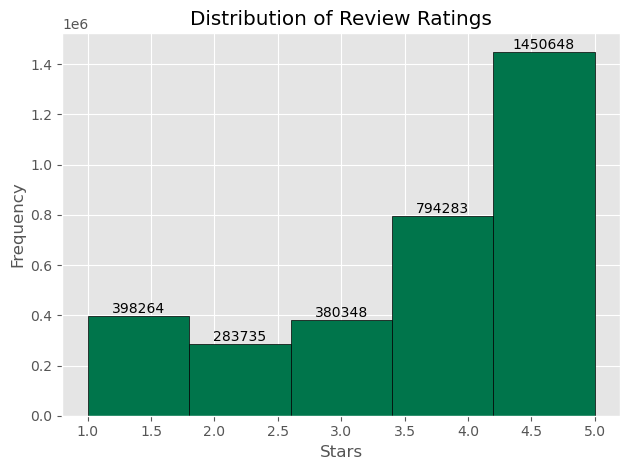

In [7]:
train = train[['text', 'stars']]

train_counts, train_bins, train_patches = plt.hist(
    train['stars'], bins=5, color=main_color[0], edgecolor='black')

for count, patch in zip(train_counts, train_patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    plt.text(x, y, str(int(count)), ha='center',
             va='bottom')

plt.title('Distribution of Review Ratings')
plt.xlabel('Stars')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('../static/experiments/05_Review_Rating_Distribution.png', dpi=600)
plt.show()

One-hot encode the `stars` column, creating a new column for each unique value.

If a row has that value in the original column, the new column is 1; otherwise, it's 0.

In [8]:
train = pd.get_dummies(train, columns=['stars'])
train.head()

,text,stars_1,stars_2,stars_3,stars_4,stars_5
0,"If you decide to eat here, just be aware it is...",False,False,True,False,False
2,Family diner. Had the buffet. Eclectic assortm...,False,False,True,False,False
3,"Wow! Yummy, different, delicious. Our favo...",False,False,False,False,True
4,Cute interior and owner (?) gave us tour of up...,False,False,False,True,False
5,I am a long term frequent customer of this est...,True,False,False,False,False


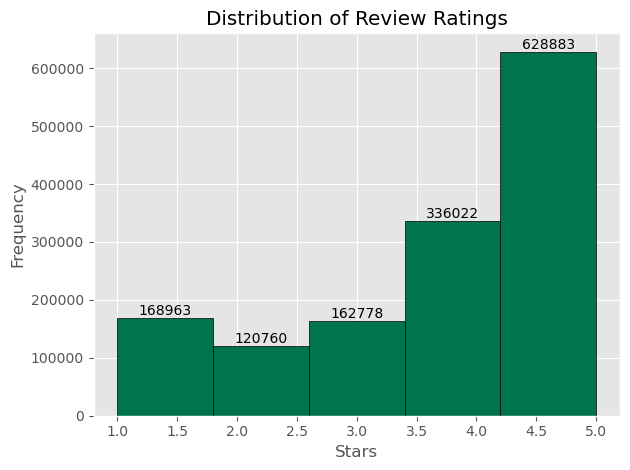

In [9]:
test_counts, test_bins, test_patches = plt.hist(
    test['stars'], bins=5, color=main_color[0], edgecolor='black')

for count, patch in zip(test_counts, test_patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    plt.text(x, y, str(int(count)), ha='center',
             va='bottom')

plt.title('Distribution of Review Ratings')
plt.xlabel('Stars')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('../static/experiments/06_Test_Set_Review_Rating_Distribution.png', dpi=600)
plt.show()

In [10]:
test = test[['text', 'stars']]
test = pd.get_dummies(test, columns=['stars'])

print(f"Current training dataset dimensions: {train.shape}")
print(f"Current test dataset dimensions: {test.shape}")

Current training dataset dimensions: (3307278, 6)
Current test dataset dimensions: (1417406, 6)


We use a Naive Bayes linear classifier along with `TfidfVectorizer` to convert review text into TF-IDF weighted word vectors. This establishes a baseline model for the NLP task by comparing word occurrence frequencies across different star ratings and computing conditional probabilities to predict the review's star rating.

In [11]:
# Set up TfidfVectorizer to use at most 2000 most important features (words) to build the word vector model.
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

Apply the Naive Bayes model to calculate the conditional probability of given words *(e.g., "this", "restaurant", "very", "terrible")* under different star ratings, and <u>use Laplace smoothing to handle unseen words</u>. The resulting Naive Bayes probabilities are used as features, combined with a logistic regression model to predict the review's star rating, thereby improving prediction accuracy and interpretability.


In [ ]:
# Create a pipeline using sklearn:
# First, use TfidfVectorizer (tfidf) to convert text into TF-IDF features.
# Then, apply the Naive Bayes feature transformer (NBFeatures) to compute probabilistic features.
# Finally, use these features in a Logistic Regression model (LogisticRegression) for final classification.

lr = LogisticRegression(max_iter=1000) 
nb = NBFeatures(1)
pl = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),      
    ('lr', lr)       
])

Since the original star ratings include multiple classes (from 1 to 5 stars), the following code transforms the ratings into multiple binary classification problems. For each class (star rating), it separately predicts the probability that a review belongs to that specific rating.

In [ ]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
scores = []  # Store cross-validation scores for each class
preds = np.zeros((len(test), len(class_names)))

f = open('cv_scores.txt', 'w')

# Iterate over each star rating class to train and predict for each binary classification task
for _, class_name in enumerate(class_names):
    train_target = train[class_name]  # Get target values for the current star rating class

    # Compute cross-validation score for the current class
    cv_score = np.mean(cross_val_score(estimator=pl,
                                       X=train['text'].values,
                                       y=train_target,
                                       cv=3,
                                       scoring='accuracy'))

    scores.append(cv_score)

    print('CV score for class {} is {}'.format(class_name, cv_score))
    f.write('CV score for class {} is {}\n'.format(class_name, cv_score))

    pl.fit(train['text'].values, train_target)
    preds[:, _] = pl.predict_proba(test['text'].values)[
        :, 1]

f.close()

CV score for class stars_1 is 0.9379220615865979
CV score for class stars_2 is 0.9125549772350555
CV score for class stars_3 is 0.8880227183804928
CV score for class stars_4 is 0.7738614655314734
CV score for class stars_5 is 0.8192752468948785


We use sklearn's classification_report to generate a performance report for the classification model.

- `y_true`: the true labels, obtained by taking the index of the maximum value across the class_names columns in the test_sample dataset
- `y_pred`: the predicted labels, obtained by taking the index of the maximum value across the prediction results in preds


In [14]:
NBF_report = metrics.classification_report(
    y_true=np.argmax(test[class_names].values, axis=1),
    y_pred=np.argmax(preds, axis=1))
print(NBF_report)

              precision    recall  f1-score   support

           0       0.68      0.82      0.74    168963
           1       0.49      0.26      0.34    120760
           2       0.51      0.34      0.41    162778
           3       0.52      0.44      0.48    336022
           4       0.74      0.89      0.81    628883

    accuracy                           0.66   1417406
   macro avg       0.59      0.55      0.55   1417406
weighted avg       0.63      0.66      0.64   1417406



## Part Two: Neural network model based on GloVe word embeddings

This section uses GloVe embeddings as word vectors and employs the Keras framework to build and train a neural network model, aiming to improve classification accuracy and interpretability of the review text.


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

2025-04-24 14:57:58.310920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 14:57:58.331690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745477878.354305   21402 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745477878.360669   21402 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745477878.375745   21402 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [17]:
lengths = review_df['text'].str.len()

# Compute and print key statistics
print("Minimum text length:", lengths.min())
print("Maximum text length:", lengths.max())
print("Average text length:", lengths.mean())
print("Median text length:", lengths.median())
print("Standard deviation of text length:", lengths.std())

Minimum text length: 1
Maximum text length: 5000
Average text length: 567.7644364746477
Median text length: 406.0
Standard deviation of text length: 527.2578085249494


In [18]:
# Set the embedding dimension to 300; each word will be represented as a 300-dimensional vector
embed_size = 300
# Set the maximum number of features (vocabulary size) to 50,000; at most 50,000 distinct words will be used in the model
max_features = 50000
# Set the maximum sequence length to 600; each review will use at most 600 words
maxlen = 600

embedding_file = '../assets/GloVe/glove.840B.300d.txt'

embeddings_index = {}

with open(embedding_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError as e:
            # print(f"Skipped line: {line}")
            continue


In [19]:
 # Print the number of words loaded from the GloVe embedding file
print(len(embeddings_index))

2195884


In [20]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']

y = train[class_names].values

Use Keras's `pad_sequences` method to pad the tokenized text data, ensuring all vectors have a uniform length to meet the input requirements of the neural network model.

In [21]:
# Initialize a Tokenizer object with the maximum vocabulary size defined by max_features
tokenizer = Tokenizer(num_words=max_features)

# Fit the tokenizer on the text column of the train dataset to build the word index
tokenizer.fit_on_texts(list(train['text'].values))

# Convert the training and test text into sequences of integers,
# where each word is replaced by its index in the tokenizer's vocabulary
X_train = tokenizer.texts_to_sequences(train['text'].values)
X_test = tokenizer.texts_to_sequences(test['text'].values)

# Use the pad_sequences method to pad the training and test sequences to the same maximum length
# Sequences shorter than maxlen are padded with the default value (0)
x_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(X_test, maxlen=maxlen)

Initialize word embeddings; words not found in the pretrained embeddings will be assigned zero vectors. These embeddings are trainable, allowing them to be updated during model training.

In [22]:
# Retrieve the word index dictionary from the tokenizer
word_index = tokenizer.word_index

# Determine the size of the embedding matrix: the smaller of max_features or the size of the word index
nb_words = min(max_features, len(word_index))

# Create a zero matrix with shape (nb_words, embed_size) to store word vectors
embedding_matrix = np.zeros((nb_words, embed_size))

missed = []

for word, _ in word_index.items():
    # Only process words with indices less than max_features to keep the embedding_matrix at the right size
    if _ >= max_features:
        break
    # Retrieve the word vector from the pretrained embeddings
    embedding_vector = embeddings_index.get(word)
    # If the vector exists, assign it to the corresponding row in embedding_matrix
    if embedding_vector is not None:
        embedding_matrix[_] = embedding_vector
    else:
        # If the vector is not found, add the word to the missed list
        missed.append(word)

In [23]:
# Get the number of words not found in the pretrained embeddings
len(missed)

7137

Analyzing `missed` reveals that many unrecognized words contain apostrophes (`'`), which may lead to incorrect interpretations by the model. However, since the model only considers the first 600 words per review, the overall impact should be limited.

Set up the pretrained GloVe embeddings and allow them to be fine-tuned during training by setting `trainable=True`. This helps the model better adapt to the specific dataset and improves prediction accuracy.


### Model training for the neural network based on GloVe embeddings

In [ ]:
# Define the model's input layer with shape (maxlen,), representing the length of each input sample
inp = Input(shape=(maxlen,))

# Create the embedding layer using the preloaded word embedding matrix and set it as trainable
x = Embedding(max_features, embed_size, weights=[
              embedding_matrix], trainable=True)(inp)

# Add spatial dropout to reduce overfitting to specific word positions
x = SpatialDropout1D(0.5)(x)

# Use a bidirectional LSTM layer to process the sequential data
x = Bidirectional(layer=LSTM(units=40, return_sequences=True))(x)

# Add an additional bidirectional GRU layer to enhance the model's learning capability
x = Bidirectional(layer=GRU(units=40, return_sequences=True))(x)

# Use global average pooling and global max pooling layers to extract features
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

# Concatenate the results of average and max pooling to capture diverse feature representations
conc = concatenate([avg_pool, max_pool])

# Output layer with sigmoid activation function, outputting 5 units (for 5 star classes)
outp = Dense(units=5, activation='sigmoid')(conc)

# Define the model with inp as input and outp as output
model_glove_lstm_gru = Model(inputs=inp, outputs=outp)

# Define early stopping callback to terminate training when validation loss stops improving
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

# Define model checkpoint callback to save the model with the best validation loss
checkpoint = ModelCheckpoint(
    monitor='val_loss',
    save_best_only=True,
    filepath='../assets/weights/yelp_lstm_gru_weights_300.keras')

# Compile the model using binary crossentropy loss and Adam optimizer, tracking accuracy
model_glove_lstm_gru.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

I0000 00:00:1745478353.598146   21402 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15828 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:16:00.0, compute capability: 8.9
I0000 00:00:1745478353.598807   21402 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22321 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:39:00.0, compute capability: 8.9


In [ ]:
model_glove_lstm_gru.fit(
    x_train,                            
    y,                                  
    batch_size=512,                     
    epochs=50,                          
    validation_split=0.2,               
    callbacks=[earlystop, checkpoint]
)


Epoch 1/50


I0000 00:00:1745478369.774299   24191 cuda_dnn.cc:529] Loaded cuDNN version 90300


5168/5168 ━━━━━━━━━━━━━━━━━━━━ 973s 187ms/step - accuracy: 0.6505 - loss: 0.2862 - val_accuracy: 0.7306 - val_loss: 0.2296
Epoch 2/50
5168/5168 ━━━━━━━━━━━━━━━━━━━━ 965s 187ms/step - accuracy: 0.7190 - loss: 0.2366 - val_accuracy: 0.7386 - val_loss: 0.2235
Epoch 3/50
5168/5168 ━━━━━━━━━━━━━━━━━━━━ 966s 187ms/step - accuracy: 0.7305 - loss: 0.2287 - val_accuracy: 0.7406 - val_loss: 0.2217
Epoch 4/50
5168/5168 ━━━━━━━━━━━━━━━━━━━━ 961s 186ms/step - accuracy: 0.7359 - loss: 0.2247 - val_accuracy: 0.7420 - val_loss: 0.2205
Epoch 5/50
5168/5168 ━━━━━━━━━━━━━━━━━━━━ 978s 189ms/step - accuracy: 0.7412 - loss: 0.2212 - val_accuracy: 0.7407 - val_loss: 0.2215
Epoch 6/50
5168/5168 ━━━━━━━━━━━━━━━━━━━━ 971s 188ms/step - accuracy: 0.7449 - loss: 0.2189 - val_accuracy: 0.7431 - val_loss: 0.2209
Epoch 7/50
5168/5168 ━━━━━━━━━━━━━━━━━━━━ 971s 188ms/step - accuracy: 0.7490 - loss: 0.2162 - val_accuracy: 0.7408 - val_loss: 0.2219


### Model evaluation for the neural network based on GloVe embeddings


In [ ]:
y_test = model_glove_lstm_gru.predict(
    [x_test],
    batch_size=1024,
    verbose=1
)

model_glove_lstm_gru.evaluate(
    x_test,
    test[class_names].values,
    verbose=1,
    batch_size=1024
)

NN_report = metrics.classification_report(
    np.argmax(test[class_names].values, axis=1),
    np.argmax(y_test, axis=1)
)

print(NN_report)
model_glove_lstm_gru.save('../assets/weights/model_glove_lstm_gru.keras')

/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(1024, 600))',)
  warnings.warn(msg)


1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

/root/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 600))',)
  warnings.warn(msg)


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 98s 70ms/step
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 112s 81ms/step - accuracy: 0.7257 - loss: 0.2319
              precision    recall  f1-score   support

           0       0.77      0.85      0.81    168963
           1       0.59      0.45      0.51    120760
           2       0.60      0.61      0.61    162778
           3       0.63      0.59      0.61    336022
           4       0.82      0.87      0.85    628883

    accuracy                           0.73   1417406
   macro avg       0.68      0.67      0.68   1417406
weighted avg       0.73      0.73      0.73   1417406

